## Import needed Libraries

This model will use ARIMA to predict upcoming stock prices. The model will be trained on time series data.

In [47]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from pandas_datareader import data as pdr
from pmdarima.arima import auto_arima
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

### Choice of Stock

In [48]:
stock = yf.Ticker("JPM")


### This section will retrieve all stock splits and dividends to provide a more informative dataframe

In [49]:
#Fetch current dividends and stock splits 
dividends = stock.dividends
splits = stock.splits

#Display all stock price history 
stock = stock.history(period="max")
df = stock

#insert the retrieved data into dataframe
df['Stock Splits'] = splits
df['Dividends'] = dividends

#fill all NaN values with 0
df['Dividends'].fillna(0, inplace=True)
df['Stock Splits'].fillna(0, inplace=True)

pd.set_option('display.expand_frame_repr', False)

#Display amount of rows wanted
pd.set_option('display.max_rows', 20)  
pd.set_option('display.min_rows', 10) 

#Only display data from the year 2007 up till now (2023)    
df = df.loc['2007-03-07':]
print(df)
    
    
    

                                 Open        High         Low       Close    Volume  Dividends  Stock Splits
Date                                                                                                        
2007-03-07 00:00:00-05:00   31.426647   31.542827   31.149106   31.213652  13664500        0.0           0.0
2007-03-08 00:00:00-05:00   31.491185   31.852632   31.381459   31.458914  11979500        0.0           0.0
2007-03-09 00:00:00-05:00   31.704199   31.852651   31.323387   31.510567   9452900        0.0           0.0
2007-03-12 00:00:00-04:00   31.394379   31.613830   31.368560   31.523468  10445700        0.0           0.0
2007-03-13 00:00:00-04:00   31.271752   31.304024   30.051864   30.142225  25294400        0.0           0.0
...                               ...         ...         ...         ...       ...        ...           ...
2023-11-10 00:00:00-05:00  144.940002  146.479996  144.080002  146.429993   7983300        0.0           0.0
2023-11-13 00:00:00

## Graphing Closing Prices from 2007 to Present Day

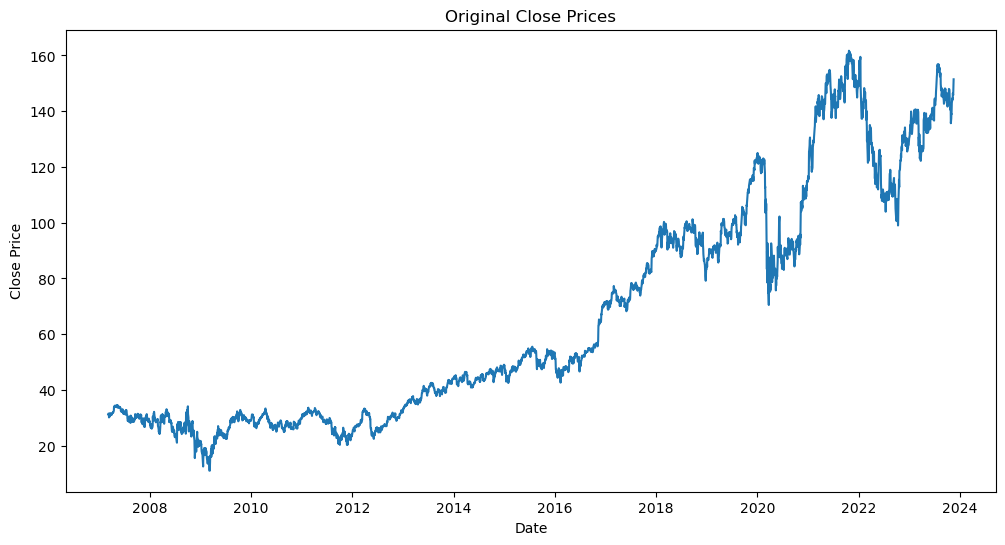

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('Original Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


### Print the dividend paid on a certain date  

In [51]:
desired_date = '2023-10-05'
dividend_data = df.loc[desired_date]['Dividends'] 
print(dividend_data)

1.05


### Print all instances were dividends were paid from 2007 up till now

In [54]:
num_rows_to_print = 20  # Only getting the last 20 rows to print

# Filter DataFrame for rows with dividends greater than 0
dividend_rows = df[df['Dividends'] > 0]

# Get the last 'num_rows_to_print' rows from the filtered DataFrame
last_rows_to_print = dividend_rows.tail(num_rows_to_print)

# Loop through the filtered DataFrame and print dates with dividends greater than 0
for date in last_rows_to_print.index:
    formatted_date = date.strftime('%Y-%m-%d')  # Remove time stamps
    print(f"Date: {formatted_date}, Dividends: {df['Dividends'][date]}")


Date: 2019-01-03, Dividends: 0.8
Date: 2019-04-04, Dividends: 0.8
Date: 2019-07-03, Dividends: 0.8
Date: 2019-10-03, Dividends: 0.9
Date: 2020-01-03, Dividends: 0.9
Date: 2020-04-03, Dividends: 0.9
Date: 2020-07-02, Dividends: 0.9
Date: 2020-10-05, Dividends: 0.9
Date: 2021-01-05, Dividends: 0.9
Date: 2021-04-05, Dividends: 0.9
Date: 2021-07-02, Dividends: 0.9
Date: 2021-10-05, Dividends: 1.0
Date: 2022-01-05, Dividends: 1.0
Date: 2022-04-05, Dividends: 1.0
Date: 2022-07-05, Dividends: 1.0
Date: 2022-10-05, Dividends: 1.0
Date: 2023-01-05, Dividends: 1.0
Date: 2023-04-05, Dividends: 1.0
Date: 2023-07-05, Dividends: 1.0
Date: 2023-10-05, Dividends: 1.05


## Check Existence of Desired Date
This will check whether the date is seen within the dataframe in order to execute the code after

In [55]:
desired_date = '2023-10-02'

if desired_date in df.index:
    print('Yes the date is there')
else:
    print('Date does not exist')



Yes the date is there


## Print Closing Price of Desired Date
This will provide the closing price on the day needed 

In [56]:
the_price = df.loc[desired_date]['Close']
print(the_price)

142.7169189453125


## Calculate the 50 Day Slow Moving Average (SMA)
This will provide the sma with a window size of 50 and create a new column in the dataframe named 'Sma_50'

In [57]:
ma = 50
sma = "Sma_" + str(ma)

# Use .loc for both assignment and selection
df = df.copy()  # Create a copy of the DataFrame
df.loc[:, sma] = df.iloc[:, 3].rolling(window=ma).mean()
df = df.iloc[ma:]

df_copy = df.copy()

# Drop the "Stock Splits" and "Dividends" columns from the copy
df_copy = df_copy.drop(["Stock Splits", "Dividends"], axis=1)

pd.set_option('display.max_rows', 40)  # Set the maximum number of rows you want to display
pd.set_option('display.min_rows', 20)

# Display the modified DataFrame
print(df_copy)





                                 Open        High         Low       Close    Volume      Sma_50
Date                                                                                           
2007-05-17 00:00:00-04:00   34.308310   34.451316   34.126304   34.165306   9049900   32.580689
2007-05-18 00:00:00-04:00   34.204318   34.405826   34.093815   34.152317  11115100   32.634557
2007-05-21 00:00:00-04:00   34.048301   34.327812   34.002800   34.165306  10408300   32.687652
2007-05-22 00:00:00-04:00   34.165326   34.243328   33.859813   33.989819   9665800   32.736979
2007-05-23 00:00:00-04:00   34.015816   34.217322   33.755805   33.794807  11246900   32.810031
2007-05-24 00:00:00-04:00   33.801308   33.957315   33.443795   33.534798  13105800   32.870137
2007-05-25 00:00:00-04:00   33.495780   33.703788   33.320273   33.567284  10761300   32.925729
2007-05-29 00:00:00-04:00   33.573789   33.749293   33.443783   33.684292   9552300   32.992311
2007-05-30 00:00:00-04:00   33.430796   

## Graphing SMA 50 with Closing Price 
This will help smooth out price data by creating a constantly updated average price

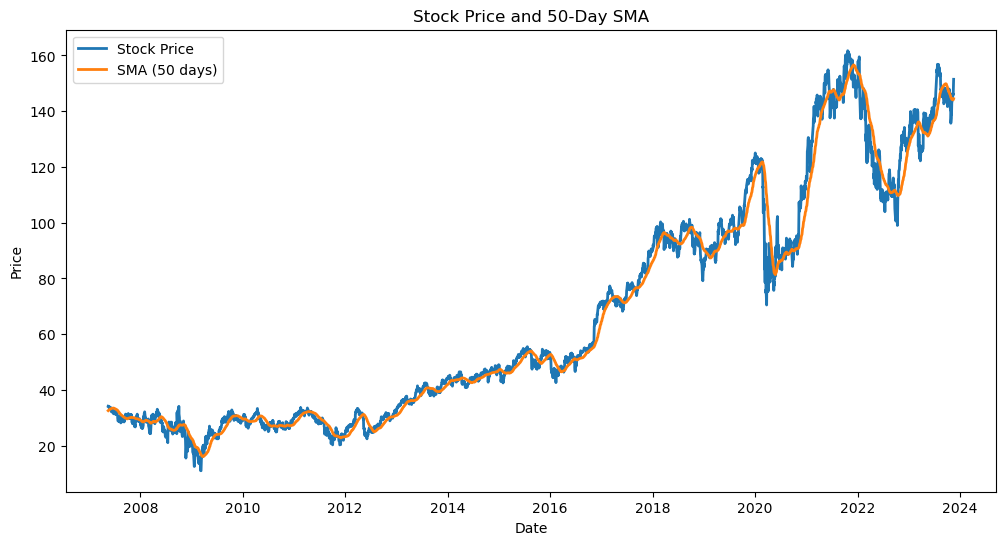

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the stock's closing prices
ax.plot(df.index, df['Close'], label='Stock Price', linewidth=2)

# Plot the SMA
ax.plot(df.index, df['Sma_50'], label='SMA (50 days)', linewidth=2)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Stock Price and 50-Day SMA')

# Add a legend
ax.legend()

# Show the plot
plt.show()


## ROI Calculator 
This was a fun way to figure out how much you would have made if you invested at a certain period with any amount of your choice. In this case how much would you have made if you invested in the stock during 2007 with $10,000?

In [59]:
initial_investment = 10000
initial_date = '2007-07-30'

initial_date_price = df.loc[initial_date]['Close']

num_shares = initial_investment / initial_date_price
current_price = df['Close'].iloc[-1]

return_stock = num_shares * current_price
profit = return_stock - initial_investment
print(f"If you invested ${initial_investment:.2f} on {initial_date}, you could have bought about {num_shares:.2f} shares.")
print(f"The current price per share is ${current_price:.2f}.")
print(f"Your investment would be worth ${return_stock:.2f} now.")
print(f"This means you would have made a profit of about ${profit:.2f}.")

If you invested $10000.00 on 2007-07-30, you could have bought about 341.12 shares.
The current price per share is $151.45.
Your investment would be worth $51662.47 now.
This means you would have made a profit of about $41662.47.


## Beginning stages of creating ARIMA Model
Before utilising the ARIMA model, we must split the data into its training and test split

In [60]:
rows_trained = int(len(df)*0.9)

train_split = list(df[0:rows_trained]['Close'])
test_split = list(df[rows_trained:]['Close'])
print(f'The amount of rows I will use to train the data on is {len(train_split)}')
print(f'The amount of rows I will use to test the data on is {len(test_split)}')

The amount of rows I will use to train the data on is 3740
The amount of rows I will use to test the data on is 416


## Graph what data will be trained and what data will be tested
The navy line illustrates the training data whilst the blue line illustrates how much of the data will be tested on. The 3718 rows will therefore, be the navy line whilst the 414 that are being tested is the blue line. 

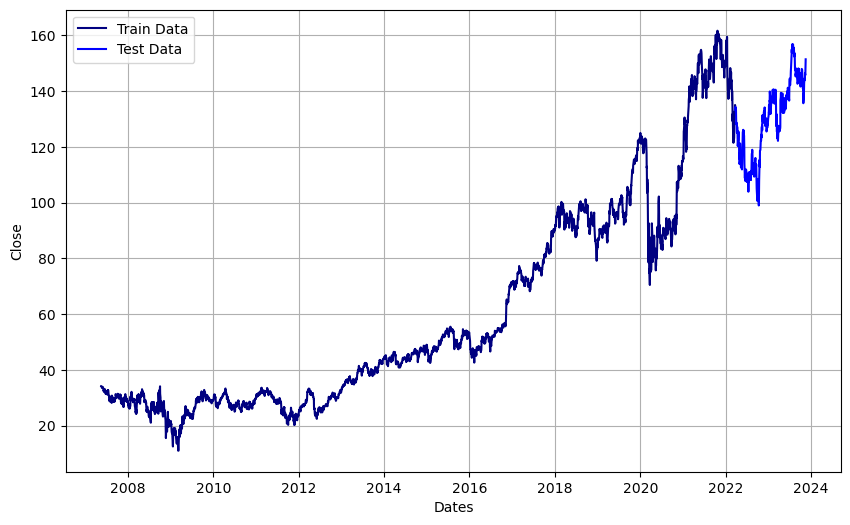

In [61]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close')
plt.plot(df[0:rows_trained]['Close'], 'navy', label='Train Data')
plt.plot(df[rows_trained:]['Close'], 'blue', label='Test Data')
plt.legend()

## Create predictions list 
This section will calculate the number of observations that will be done on the testing split data

In [62]:
predictions = []  # Use the correct variable name here
n_test_obser = len(test_split)
print(n_test_obser)

416


# ARIMA Model Prediction Loop
This loop iteratively applies an ARIMA model to forecast stock prices.
 - Order (p, d, q): The ARIMA model is defined by three parameters - p, d, and q:
 - p (Number of Lag Observations): This tells the model how far back in time it should look to help predict the        future values. If it's set to 4, the model will check the last 4 days ( also known as time steps) to help make      its prediction. In other words, its checking to see the prices 4 days ago.
 - d (Degree of Differencing): This tells the model how many times the data needs to be adjusted to make it more      predictable. If it's set to 1, we're making one change to the raw data that has variations or irregularities.      Thus refinifing the data to help create a forecast. 
 - Order of the Moving Average (q): This specifies how much past information is considered when making predictions.    If q is set to 0, only the current observation is considered. As q increases, more past observations are            included in the model, providing a broader historical perspective for making predictions. In our context, having    q as 0 means focusing on the most recent data point to make predictions. Therefore, not considering a broader      historical view. 






In [63]:
num_rows_to_print = 20  # This will only print the last 20 rows insted of printing every output
all_dates = df[rows_trained:].index #All the dates 

for i in range(n_test_obser):
    model = ARIMA(train_split, order=(4, 1, 0))
    
    model_fit = model.fit()  # train the model with the training data
    output = model_fit.forecast() #Forecast the next time step (predict the next value using the trained model on the line above)
    predicted_value = output[0] #This takes the predicted value
    predictions.append(predicted_value) #Add the predicted value to a list with all the predicted values
    actual_test_value = test_split[i] #Get the actual value from the test set for the current step in the loop.
    
    train_split.append(actual_test_value) #This adds the actual value into the training data set so it can 
    #continue to gather new data to increase its accuracy
    
    # Print the output only for the last 'num_rows_to_print' iterations
    if i >= n_test_obser - num_rows_to_print:
        print(f"Date: {all_dates[i].strftime('%Y-%m-%d')}, Predicted Price: {predicted_value:.2f}")

Date: 2023-10-20, Predicted Price: 145.25
Date: 2023-10-23, Predicted Price: 143.10
Date: 2023-10-24, Predicted Price: 141.06
Date: 2023-10-25, Predicted Price: 141.12
Date: 2023-10-26, Predicted Price: 140.59
Date: 2023-10-27, Predicted Price: 140.78
Date: 2023-10-30, Predicted Price: 136.02
Date: 2023-10-31, Predicted Price: 137.05
Date: 2023-11-01, Predicted Price: 139.13
Date: 2023-11-02, Predicted Price: 139.23
Date: 2023-11-03, Predicted Price: 141.16
Date: 2023-11-06, Predicted Price: 142.98
Date: 2023-11-07, Predicted Price: 144.07
Date: 2023-11-08, Predicted Price: 143.94
Date: 2023-11-09, Predicted Price: 144.59
Date: 2023-11-10, Predicted Price: 144.31
Date: 2023-11-13, Predicted Price: 146.27
Date: 2023-11-14, Predicted Price: 145.92
Date: 2023-11-15, Predicted Price: 148.23
Date: 2023-11-16, Predicted Price: 149.74


In [64]:
next_output = model_fit.forecast()[0]
print(f"Next Day ({all_dates[-1] + pd.DateOffset(1)}), Predicted Price: {next_output:.2f}")

Next Day (2023-11-17 00:00:00-05:00), Predicted Price: 149.74


## Summary Explained 
- Log likelihood tells us how likely it is that our ARIMA model accurately predicts the real data we observed
- The Akaike Information Criterion (AIC) is a statistical measure that helps us compare different models and select   the one that best explains the data.
- The Bayesian Information Criterion (BIC) is another statistical measure that helps us compare different models     and select the one that best explains the data.
- HQIC, or Hannan-Quinn Information Criterion, is a model selection criterion that, like AIC and BIC, helps           evaluate the trade-off between model fit and complexity. Lower HQIC values are generally better.
- ar.L1, ar.L2, ar.L3, ar.L4: These are like the "weights" assigned to the previous values in your data to predict   the current value. A positive weight means the past values have a positive impact, and a negative weight means     the opposite.
- sigma2: This is a measure of how much the actual data points differ from the predicted values. A lower value       means the predictions are closer to the actual data.
- Coefficient (coef): The estimated impact of the variable in the model is approximately 1.8142. This means, for     every unit increase in the predictor variable, we expect the response variable to increase by about 1.8142 units.
- Standard Error (std err): The low standard error of 0.015 indicates that our estimate of the impact is quite       precise and reliable.
- Z-Score (z): The high z-score of 119.427 suggests that our estimated coefficient is significantly different from   zero. This indicates a strong statistical significance.
- P-Value (P>|z|): The extremely low p-value (0.000) further supports the statistical significance, suggesting that   the impact of the variable is highly likely not due to random chance.
- Confidence Interval ([0.025, 0.975]): The narrow range (1.784 to 1.844) of the confidence interval provides a       specific range for the true impact. We can be reasonably confident that the true effect of the variable lies       within this range.


In [65]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4155
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -7139.657
Date:                Fri, 17 Nov 2023   AIC                          14289.315
Time:                        12:12:13   BIC                          14320.974
Sample:                             0   HQIC                         14300.516
                               - 4155                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0592      0.007     -8.975      0.000      -0.072      -0.046
ar.L2          0.0581      0.008      7.480      0.000       0.043       0.073
ar.L3         -0.0165      0.008     -2.138      0.0

### Checking lengths of prediction and test list


In [66]:
print(len(predictions), len(test_split))


416 416


## Mean Absolute Percentage Error (MAPE) Calculation:
MAPE serves as a metric for assessing the precision of a forecasting model by determining the average percentage difference between predicted and actual values. A lower MAPE value in this context signifies an elevated level of accuracy.

In [67]:
mape = np.mean(np.abs(np.array(predictions) - np.array(test_split[:len(predictions)])) / np.abs(test_split[:len(predictions)]))
print('MAPE:', mape)
print(f'This means that the model is {100 - mape * 100:.2f} accurate')


MAPE: 0.011683241141261843
This means that the model is 98.83 accurate


## JPM Stock Price Prediction vs. Actual Prices
The actual price is the red line and the blue line are the predictions. The closer the dots are to the line, the better 

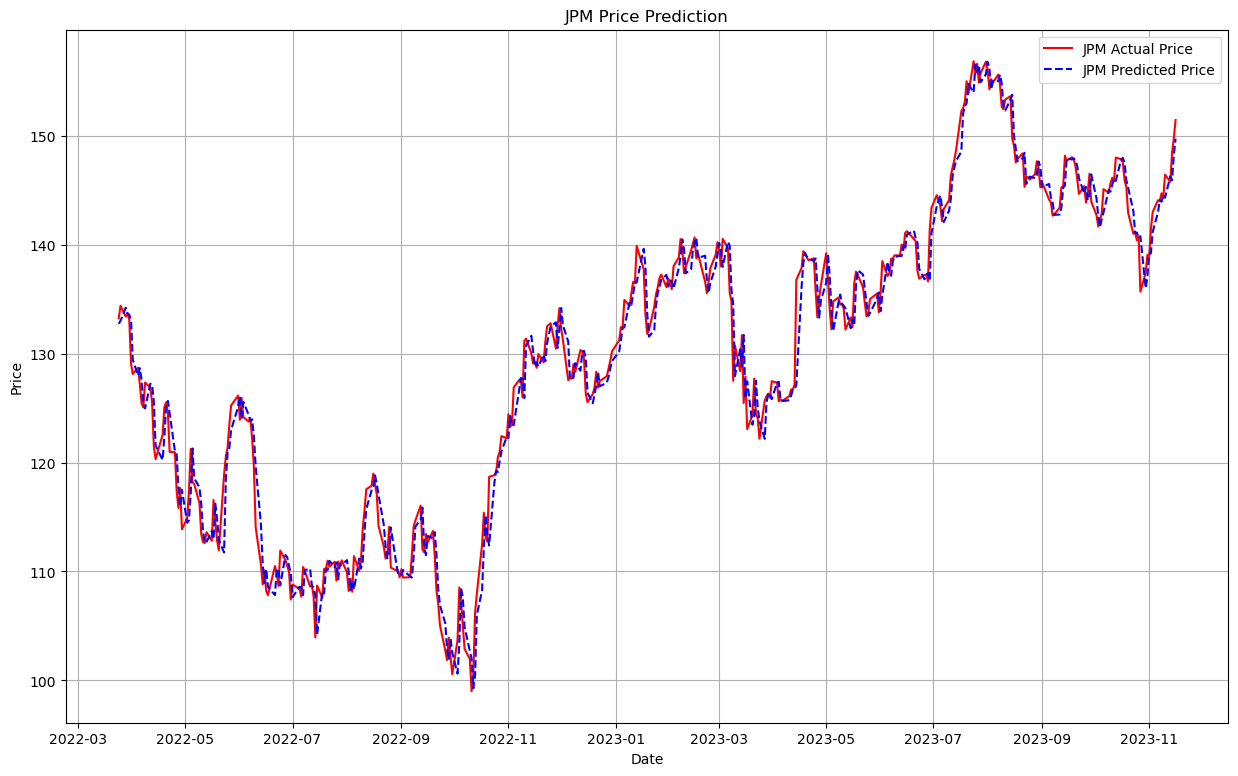

In [68]:
plt.figure(figsize=(15, 9))
plt.grid(True)

data_range = df[rows_trained:].index

plt.plot(data_range, test_split, color='red', label='JPM Actual Price')
plt.plot(data_range, predictions, color='blue', linestyle='dashed', label='JPM Predicted Price')

plt.title('JPM Price Prediction')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

## Actual Price vs Predicted Price
This looks at the previous full month and prints out the actual prices along with the predicred prices

In [69]:
all_dates = df[rows_trained:].index

all_actual_prices = test_split
all_predicted_prices = predictions

# Display the dates, actual prices, and predicted prices for the testing set in the year 2023
num_rows_to_print = 30  # This will only print the last 30 rows insted of printing every output

for date in all_dates[-num_rows_to_print:]:
    actual_price = df.loc[date, 'Close']
    predicted_price = predictions[all_dates.get_loc(date)]  # Match the index positions
    formatted_date = date.strftime('%Y-%m-%d')  # remove time stamps 
    print(f"Date: {formatted_date}, Actual Price: {actual_price:.2f}, Predicted Price: {predicted_price:.2f}")

Date: 2023-10-06, Actual Price: 145.10, Predicted Price: 142.97
Date: 2023-10-09, Actual Price: 144.77, Predicted Price: 145.04
Date: 2023-10-10, Actual Price: 145.65, Predicted Price: 144.87
Date: 2023-10-11, Actual Price: 146.15, Predicted Price: 145.51
Date: 2023-10-12, Actual Price: 145.81, Predicted Price: 146.08
Date: 2023-10-13, Actual Price: 148.00, Predicted Price: 145.86
Date: 2023-10-16, Actual Price: 147.85, Predicted Price: 147.80
Date: 2023-10-17, Actual Price: 147.53, Predicted Price: 147.97
Date: 2023-10-18, Actual Price: 145.91, Predicted Price: 147.52
Date: 2023-10-19, Actual Price: 145.29, Predicted Price: 145.90
Date: 2023-10-20, Actual Price: 142.95, Predicted Price: 145.25
Date: 2023-10-23, Actual Price: 141.00, Predicted Price: 143.10
Date: 2023-10-24, Actual Price: 141.17, Predicted Price: 141.06
Date: 2023-10-25, Actual Price: 140.40, Predicted Price: 141.12
Date: 2023-10-26, Actual Price: 140.76, Predicted Price: 140.59
Date: 2023-10-27, Actual Price: 135.69, 

### Average Error Percentage 
This calculates how much on average, the predicted values were off from the actual values.

In [70]:
# Actual and predicted prices
actual_prices = all_actual_prices
predicted_prices = all_predicted_prices

# Calculate absolute percentage errors
absolute_percentage_errors = [abs((actual - predicted) / actual) * 100 for actual, predicted in zip(actual_prices, predicted_prices)]

# Calculate the average percentage error
average_percentage_error = sum(absolute_percentage_errors) / len(absolute_percentage_errors)

print(f"Average Percentage Error: {average_percentage_error:.2f}%")


Average Percentage Error: 1.17%


In [88]:
print(df.index.min(), df.index.max())


2007-05-17 00:00:00-04:00 2023-11-16 00:00:00-05:00
